# SetUp

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import sys
import os

warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
df = pd.read_csv('../essentials/dataset.csv')

In [3]:
df.head(2)

,id,content,date,language,tags,title,ratings
0,377380-203583770957,من الاماكن الهاديه الجميله الممتعه في التسوق تحس انك بالخبر,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdfc8hb0r13sa7agg', 'sentiment': None}, {'value': 'c07bdfc8hb0r13sa7ah0', 'sentim...",Al Ahsa Mall by Arabian Centres,"{'normalized': 100, 'raw': 5}"
1,377380-203585579625,مساحة خضراء تتنفس فيها الهواء النقي .. المناظر الطبيعية ..الالعاب الترفيهية المناسبة للأطفال 😍😍 ...,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdncbb64t6si78ssg', 'sentiment': None}, {'value': 'c07bdofepd3oq1r123kg', 'sentim...","King Abdullah Park, Sea front","{'normalized': 100, 'raw': 5}"


In [4]:
# Load the mapping file
with open('../essentials/mappings.json', 'r') as f:
    mapping = json.load(f)

In [5]:
print(f"✓ Loaded {len(df):,} reviews from database")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Columns: {', '.join(df.columns)}")

✓ Loaded 10,000 reviews from database
  Date range: 2021-02-07T00:00:00+00:00 to 2023-10-03T06:31:00+00:00
  Columns: id, content, date, language, tags, title, ratings


In [6]:
df['ratings'].apply(type).value_counts()

ratings
<class 'str'>      9990
<class 'float'>      10
Name: count, dtype: int64

# Data Exploration

In [7]:
# Statistical summary
df.describe()

,id,content,date,language,tags,title,ratings
count,10000,10000,10000,10000,10000,10000,9990
unique,9989,8779,3133,2,189,1060,14
top,377380-203584587118,ممتاز,2021-02-12T00:00:00+00:00,ara,"[{'value': 'c07bja4bb64t6si78uog', 'sentiment': None}]",Masjid al-Haram,"{'normalized': 100, 'raw': 5}"
freq,2,118,256,7610,673,442,6033


In [8]:
# Basic dataset information
print("-"*80)
print("DATASET OVERVIEW")
print("-"*80)
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print("\n" + "-"*80)
print("COLUMN DATA TYPES")
print("-"*80)
print(df.dtypes)
print("\n" + "-"*80)
print("MISSING VALUES")
print("-"*80)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
}).sort_values('Missing Count', ascending=False)
print(missing_df)

--------------------------------------------------------------------------------
DATASET OVERVIEW
--------------------------------------------------------------------------------

Shape: 10,000 rows × 7 columns

--------------------------------------------------------------------------------
COLUMN DATA TYPES
--------------------------------------------------------------------------------
id          object
content     object
date        object
language    object
tags        object
title       object
ratings     object
dtype: object

--------------------------------------------------------------------------------
MISSING VALUES
--------------------------------------------------------------------------------
         Missing Count  Percentage
ratings             10         0.1


# Flatten columns

In [9]:
# Add the root directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

In [10]:
from src.data.normalize_data import extract_ratings , flatten_tags , print_duplicate_offer_destination

In [11]:
df[['normalized_ratings', 'raw_ratings']] = df['ratings'].apply(extract_ratings)

In [12]:
df.head(1)

,id,content,date,language,tags,title,ratings,normalized_ratings,raw_ratings
0,377380-203583770957,من الاماكن الهاديه الجميله الممتعه في التسوق تحس انك بالخبر,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdfc8hb0r13sa7agg', 'sentiment': None}, {'value': 'c07bdfc8hb0r13sa7ah0', 'sentim...",Al Ahsa Mall by Arabian Centres,"{'normalized': 100, 'raw': 5}",100.0,5.0


In [13]:
df = flatten_tags(df, mapping, tags_col="tags", drop_original=False)

In [14]:
df.head(1)

,id,content,date,language,tags,title,ratings,normalized_ratings,raw_ratings,offer,destination,offer_2,destination_2,offer_3,destination_3,offer_4,destination_4,offer_5,destination_5
0,377380-203583770957,من الاماكن الهاديه الجميله الممتعه في التسوق تحس انك بالخبر,2021-04-11T06:45:00+00:00,ara,"[{'value': 'c07bdfc8hb0r13sa7agg', 'sentiment': None}, {'value': 'c07bdfc8hb0r13sa7ah0', 'sentim...",Al Ahsa Mall by Arabian Centres,"{'normalized': 100, 'raw': 5}",100.0,5.0,Tourism Attractions/ Sites,Al Ahsa,Retail,Al Ahsa,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# Checking duplicates

In [15]:
num_duplicates = print_duplicate_offer_destination(df)
print(f"Number of rows with duplicate offer-destination pairs: {num_duplicates}")


Number of rows with duplicate offer-destination pairs: None


# Text Data Preparation & Cleaning

In [16]:
from src.data.clean_text import apply_cleaning , remove_stopwords

✓ NLP tools ready


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatima.moubara\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatima.moubara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
# Create a unified text column for analysis
df['text_for_analysis'] = df.apply(
    lambda row: row['content'] if row['language'] == 'ara' and pd.notna(row['content'])
    else row['content'] if pd.notna(row['content'])
    else '',
    axis=1
)

df['title_for_analysis'] = df.apply(
    lambda row: row['title'] if row['language'] == 'ara' and pd.notna(row['title'])
    else row['title'] if pd.notna(row['title'])
    else '',
    axis=1
)

# Calculate text length metrics for content (text_for_analysis) and title (title_for_analysis)
df['content_length'] = df['text_for_analysis'].fillna('').apply(len)
df['word_count'] = df['text_for_analysis'].fillna('').apply(lambda x: len(str(x).split()))
df['char_count'] = df['text_for_analysis'].fillna('').apply(len)

# Calculate text length metrics for title
df['title_word_count'] = df['title_for_analysis'].fillna('').apply(lambda x: len(str(x).split()))
df['title_char_count'] = df['title_for_analysis'].fillna('').apply(len)

# Print the preprocessing results
print("✓ Text preprocessing completed")
print(f"  Average word count (content): {df['word_count'].mean():.1f}")
print(f"  Average character count (content): {df['char_count'].mean():.1f}")
print(f"  Average word count (title): {df['title_word_count'].mean():.1f}")
print(f"  Average character count (title): {df['title_char_count'].mean():.1f}")
print(f"  Reviews with content: {df['content'].notna().sum():,}")
print(f"  Reviews with title: {df['title'].notna().sum():,}")


✓ Text preprocessing completed
  Average word count (content): 16.1
  Average character count (content): 91.4
  Average word count (title): 3.6
  Average character count (title): 21.4
  Reviews with content: 10,000
  Reviews with title: 10,000


In [18]:
# Assuming df is the DataFrame with your reviews data
df['cleaned_text'] = df.apply(apply_cleaning, axis=1)


In [19]:
# Apply tokenization and stopword removal
df['tokens'] = df.apply(lambda row: remove_stopwords(row['cleaned_text'], row['language']), axis=1)
df['token_count'] = df['tokens'].apply(len)

# Print results
print("✓ Text cleaning completed")
print(f"  Average tokens per review: {df['token_count'].mean():.1f}")
print(f"  Total unique tokens: {len(set([token for tokens in df['tokens'] for token in tokens])):,}")

✓ Text cleaning completed
  Average tokens per review: 12.0
  Total unique tokens: 25,968


# Distribution Analysis

In [20]:
from src.eda.visiualizations import plot_language_distribution , plot_rating_distribution , plot_top_10_destinations ,plot_offering_distribution, plot_word_count_distribution,plot_reviews_over_time

✓ Libraries imported successfully


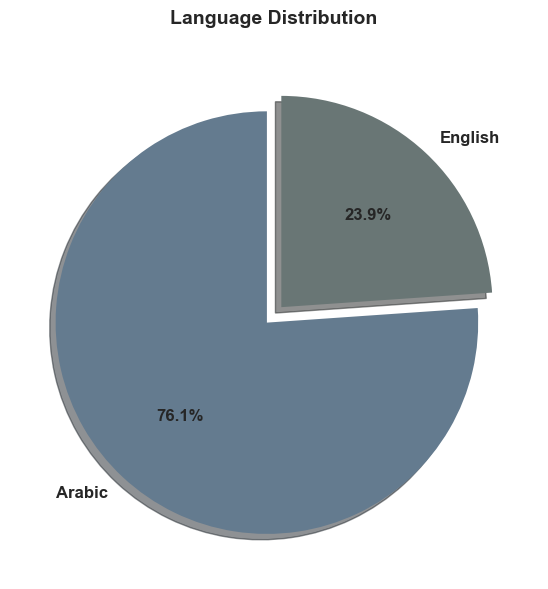

Arabic reviews: 7,610 (76.1%)
English reviews: 2,390 (23.9%)


In [21]:
plot_language_distribution(df)

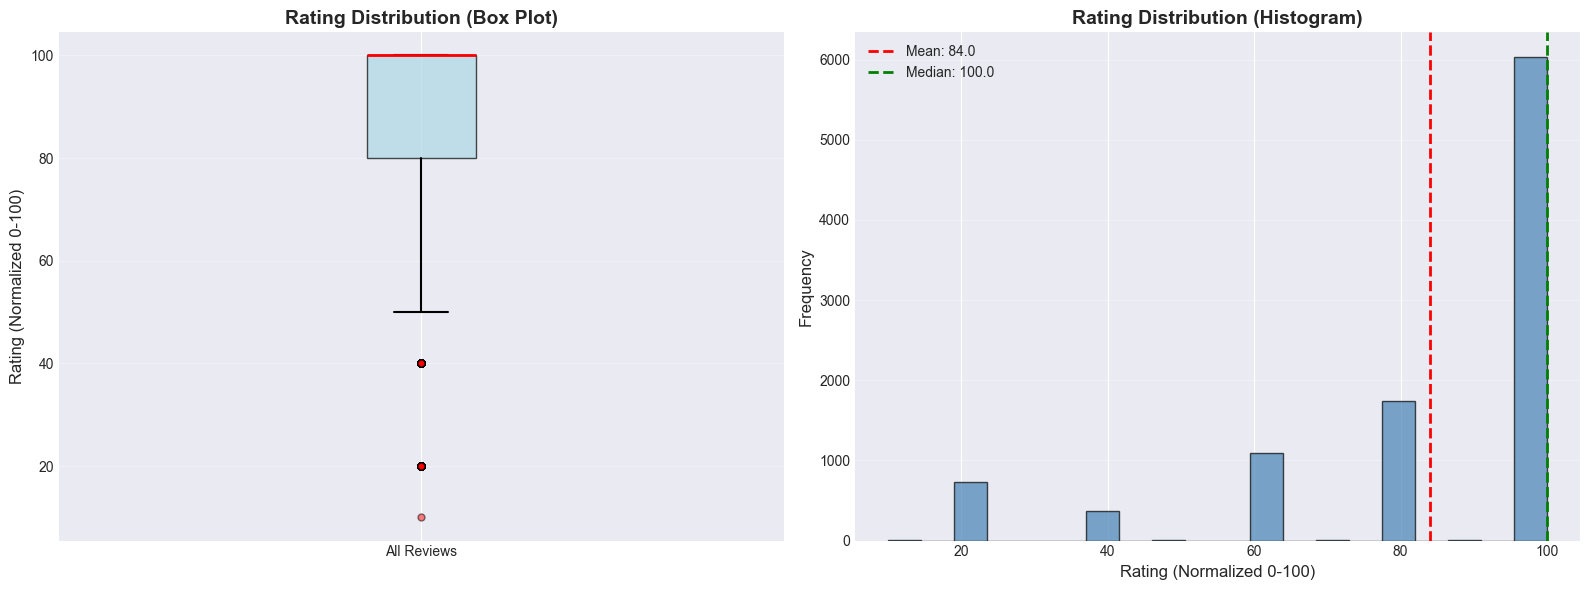

Mean rating: 84.01
Median rating: 100.00
Std deviation: 24.36


In [22]:

plot_rating_distribution(df)


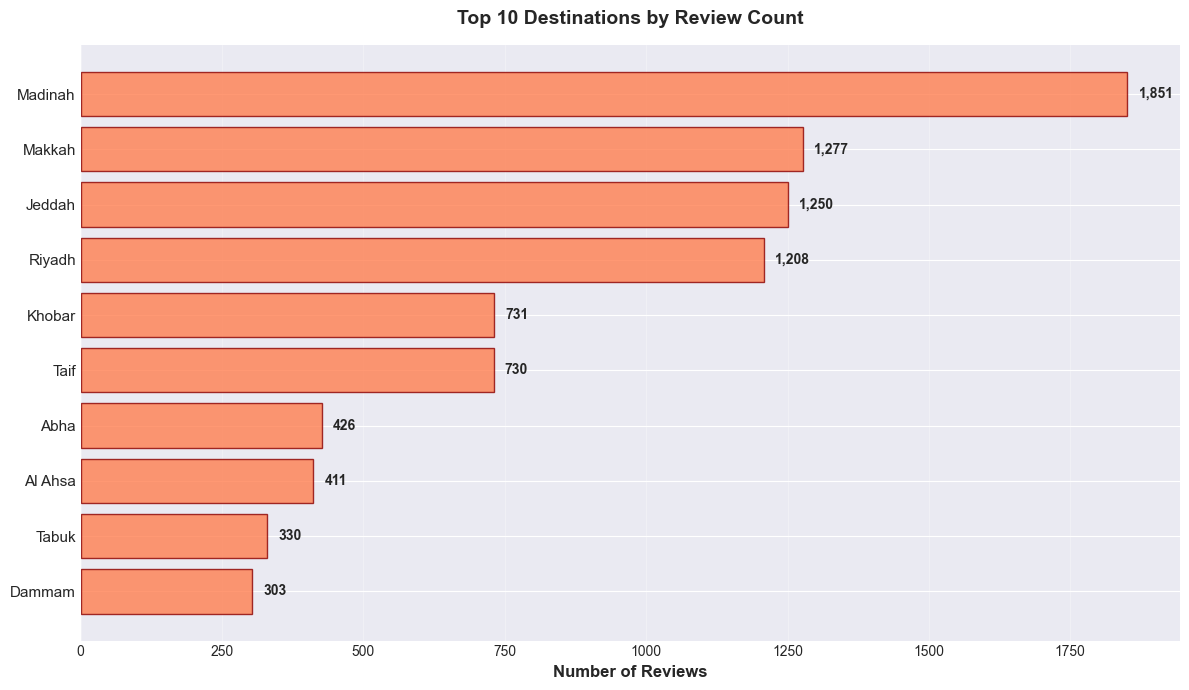

In [23]:
plot_top_10_destinations(df)

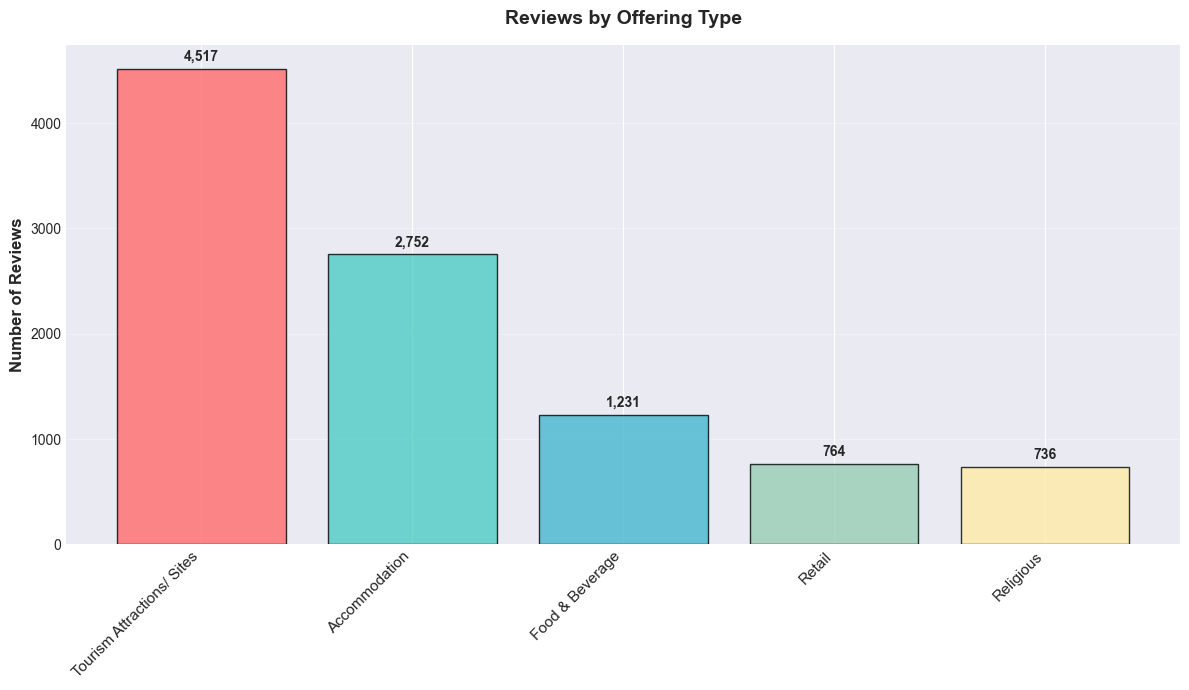

In [24]:
plot_offering_distribution(df)

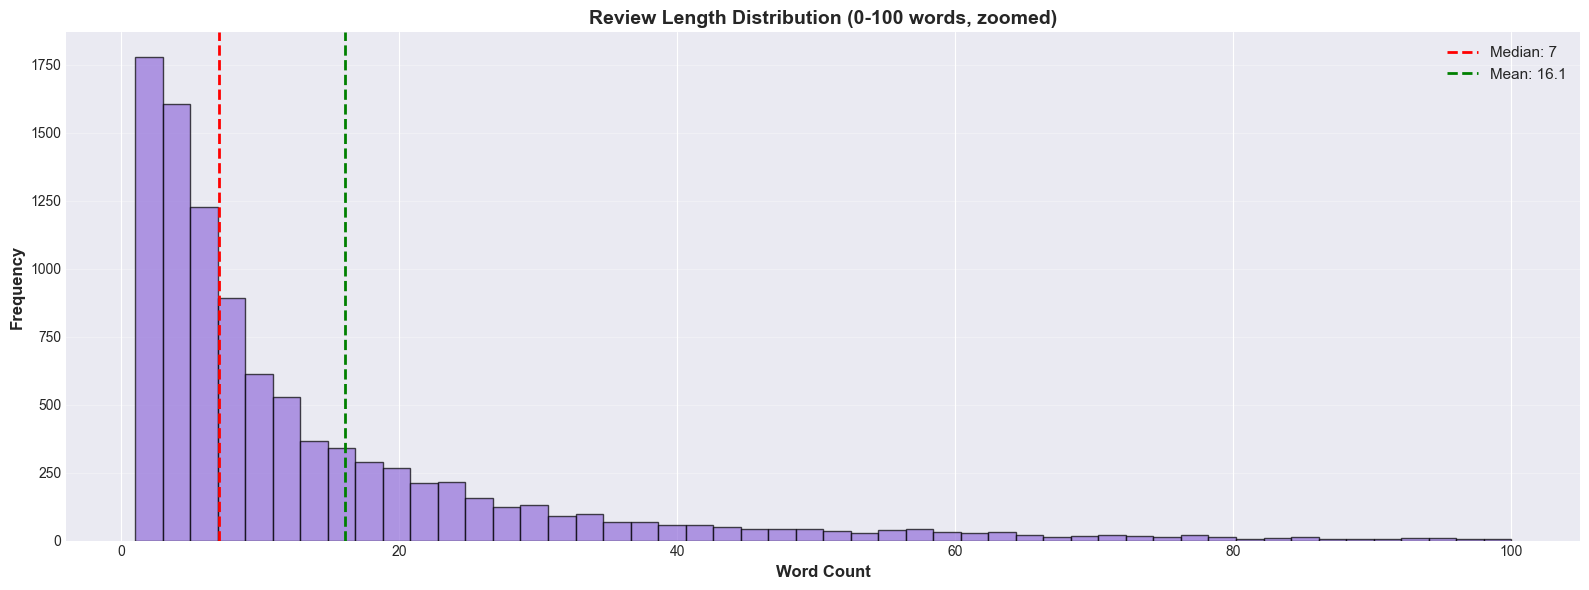

Average word count: 16.1
Median word count: 7
Max word count: 1309
Min word count: 1
95th percentile: 58
% of reviews with ≤100 words: 98.2%


In [25]:
plot_word_count_distribution(df)

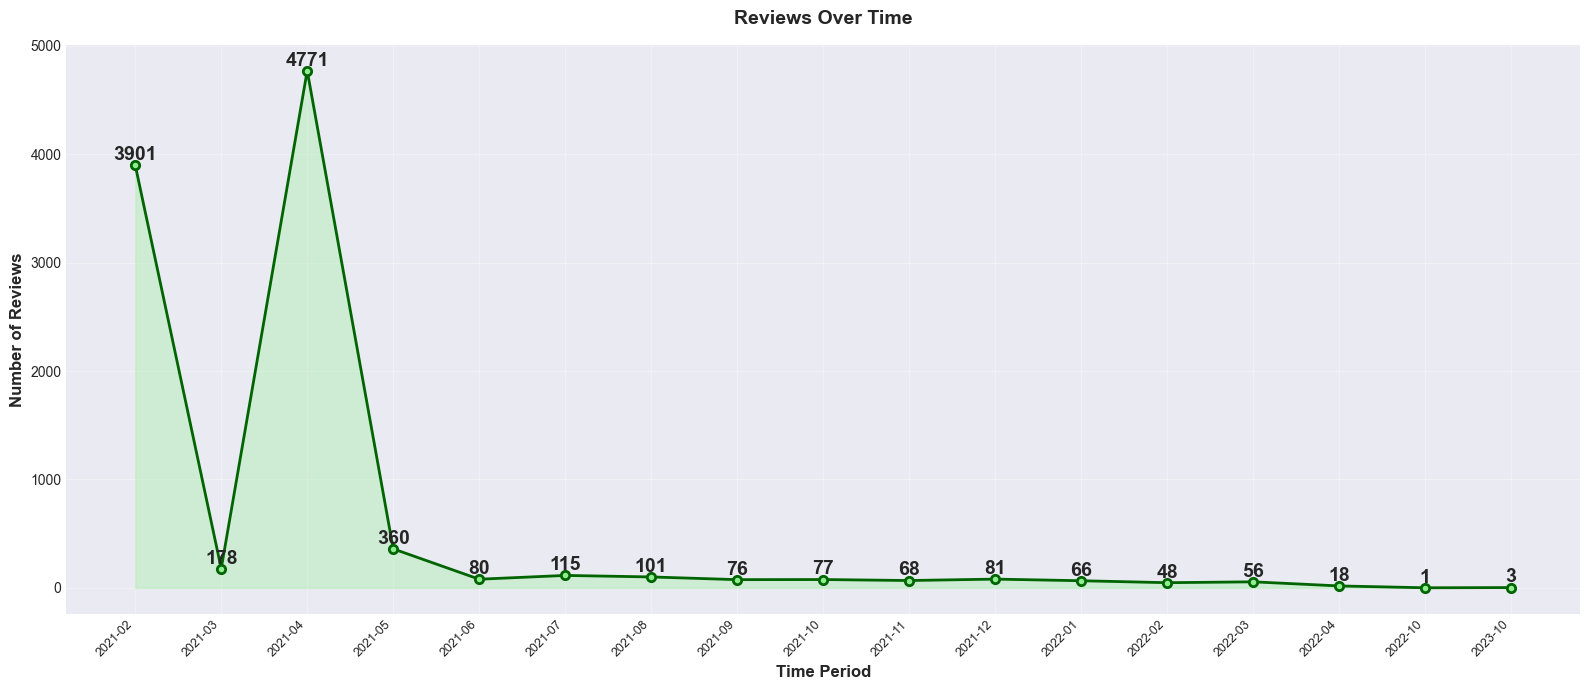

Date range: 2021-02 to 2023-10
Peak month: 2021-04 with 4,771 reviews
Average reviews per month: 588


In [26]:
plot_reviews_over_time(df)

# Destination & Offering Analysis

In [27]:
from src.eda.analysis import detailed_destination_analysis , offering_analysis , plot_destination_offering_heatmap , plot_rating_comparison

In [28]:
detailed_destination_analysis(df)

DESTINATION ANALYSIS
             Review_Count  Avg_Rating  Rating_Std  Min_Rating  Max_Rating  \
destination                                                                 
Madinah              1851       85.72       22.55        20.0       100.0   
Makkah               1277       89.01       23.02        20.0       100.0   
Jeddah               1250       81.22       26.27        20.0       100.0   
Riyadh               1208       80.09       27.88        10.0       100.0   
Khobar                731       85.18       22.67        20.0       100.0   
Taif                  730       82.60       23.99        20.0       100.0   
Abha                  426       82.58       24.15        20.0       100.0   
Al Ahsa               411       84.87       21.77        20.0       100.0   
Tabuk                 330       84.12       23.44        20.0       100.0   
Dammam                303       80.79       26.83        20.0       100.0   
Yanbu                 280       86.61       21.48      

In [29]:
offering_analysis(df)


OFFERING TYPE ANALYSIS
                            Review_Count  Avg_Rating  Rating_Std  Min_Rating  \
offer                                                                          
Tourism Attractions/ Sites          4517       85.52       22.07        20.0   
Accommodation                       2752       79.65       27.71        20.0   
Food & Beverage                     1231       80.02       27.00        10.0   
Retail                               764       85.16       22.51        20.0   
Religious                            736       96.48       13.91        20.0   

                            Max_Rating  Avg_Word_Count  
offer                                                   
Tourism Attractions/ Sites       100.0           13.89  
Accommodation                    100.0           15.97  
Food & Beverage                  100.0           20.27  
Retail                           100.0           16.37  
Religious                        100.0           22.75  


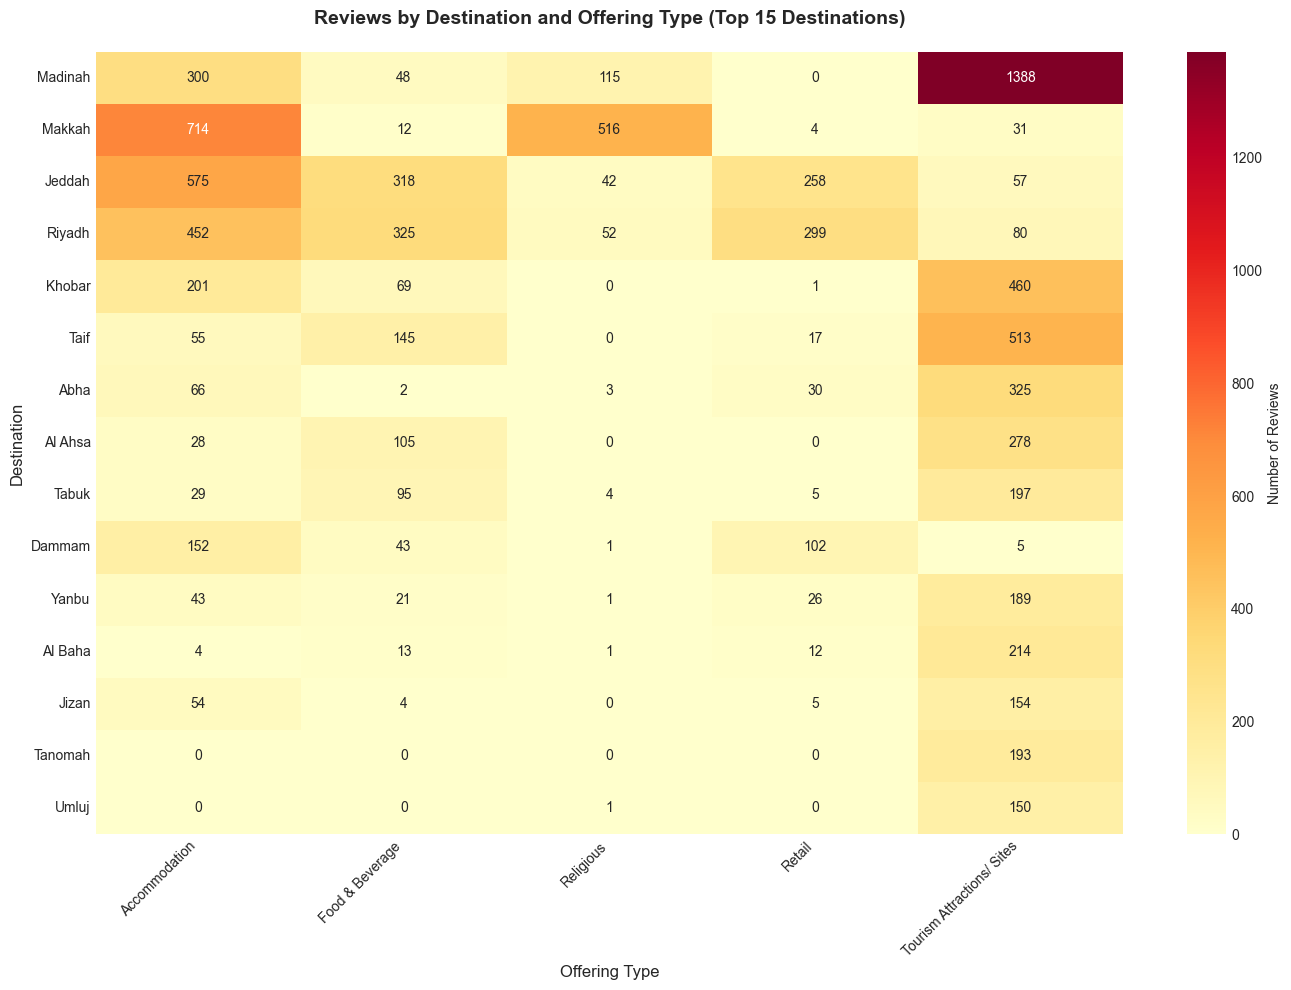

In [30]:
plot_destination_offering_heatmap(df)

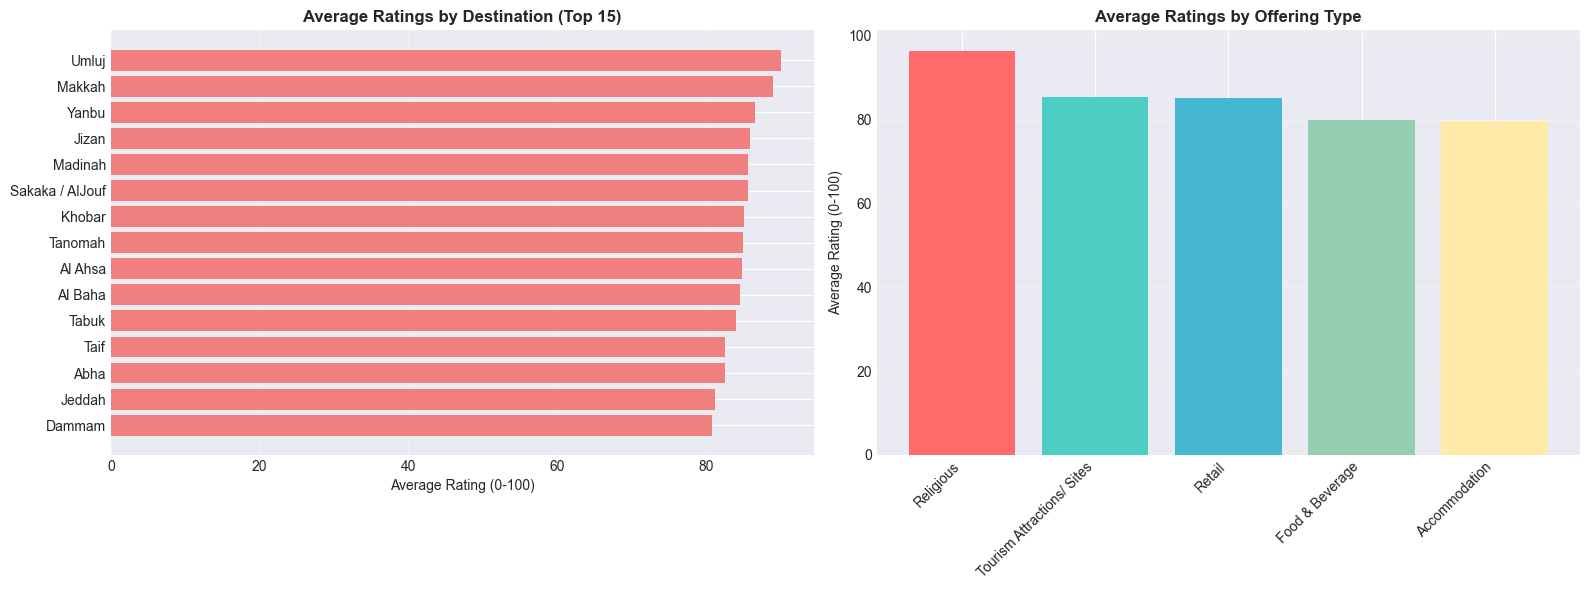

In [31]:
plot_rating_comparison(df)

# Text Analysis & NLP Insights

In [32]:
from src.eda.text_analysis import extract_most_common_words , visualize_top_words , keyword_analysis , generate_word_clouds_by_offering

In [33]:
common_words_df = extract_most_common_words(df)  
common_words_df.head(20)

TOP 10 MOST COMMON WORDS ACROSS ALL REVIEWS
 1. جدا                  - 2,026 occurrences
 2. جميل                 - 1,412 occurrences
 3. مكان                 - 878 occurrences
 4. the                  - 813 occurrences
 5. ممتاز                - 795 occurrences
 6. place                - 732 occurrences
 7. الله                 - 722 occurrences
 8. and                  - 641 occurrences
 9. google               - 617 occurrences
10. original             - 604 occurrences


,Word,Frequency
0,جدا,2026
1,جميل,1412
2,مكان,878
3,the,813
4,ممتاز,795
5,place,732
6,الله,722
7,and,641
8,google,617
9,original,604


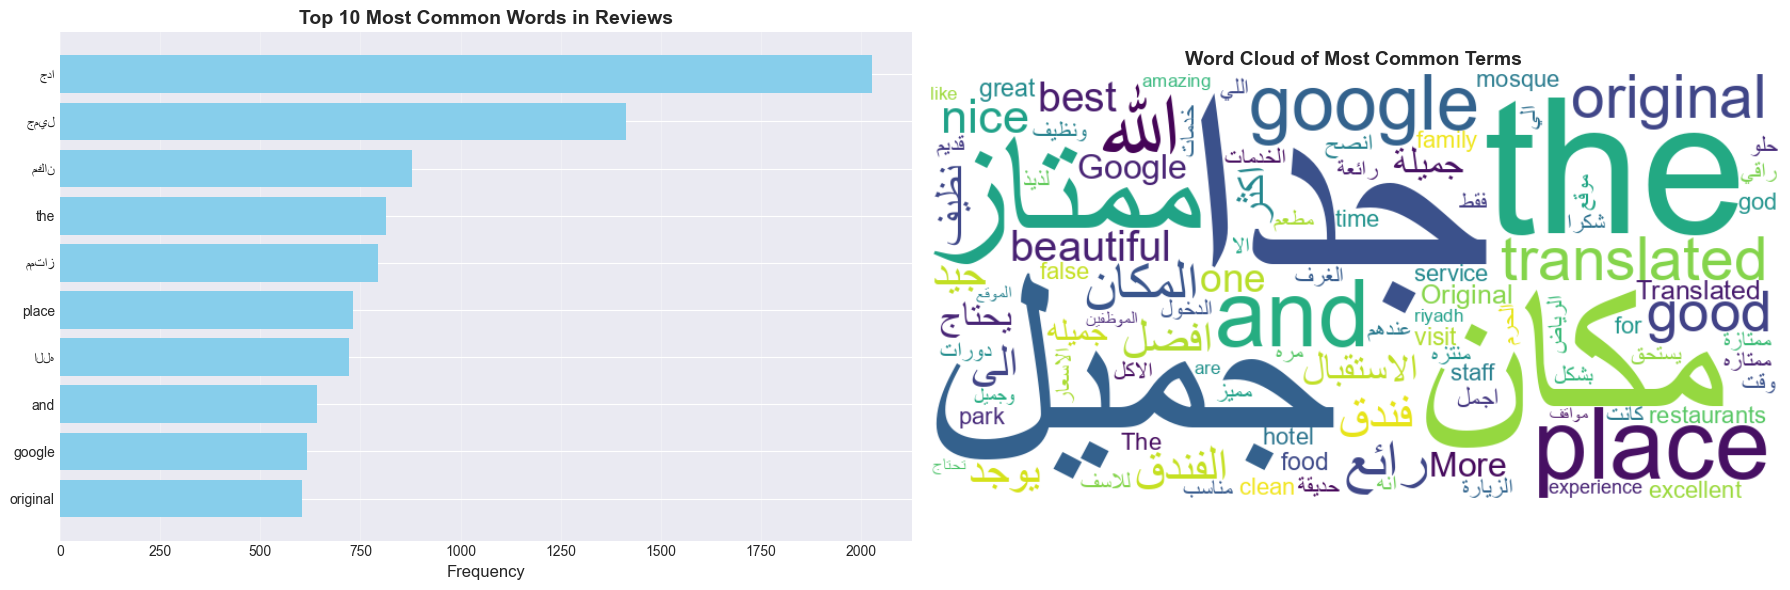

In [34]:
common_words_df = visualize_top_words(df)

In [35]:
# Example usage for Offering Type:
keyword_analysis(df, 'offer')

# Example usage for Destination:
keyword_analysis(df, 'destination')

TOP KEYWORDS BY OFFER

TOURISM ATTRACTIONS/ SITES:
----------------------------------------------------------------------------------------------------
   1. جميل            (791 times)
   2. جدا             (788 times)
   3. مكان            (593 times)
   4. place           (445 times)
   5. المكان          (322 times)
   6. the             (276 times)
   7. رائع            (268 times)
   8. ممتاز           (245 times)
   9. good            (213 times)
  10. الله            (204 times)
  11. and             (202 times)
  12. الى             (172 times)
  13. nice            (170 times)
  14. يوجد            (157 times)
  15. park            (157 times)

ACCOMMODATION:
----------------------------------------------------------------------------------------------------
   1. جدا             (759 times)
   2. فندق            (365 times)
   3. جميل            (360 times)
   4. ممتاز           (341 times)
   5. الفندق          (338 times)
   6. الاستقبال       (218 times)
   7. رائع       

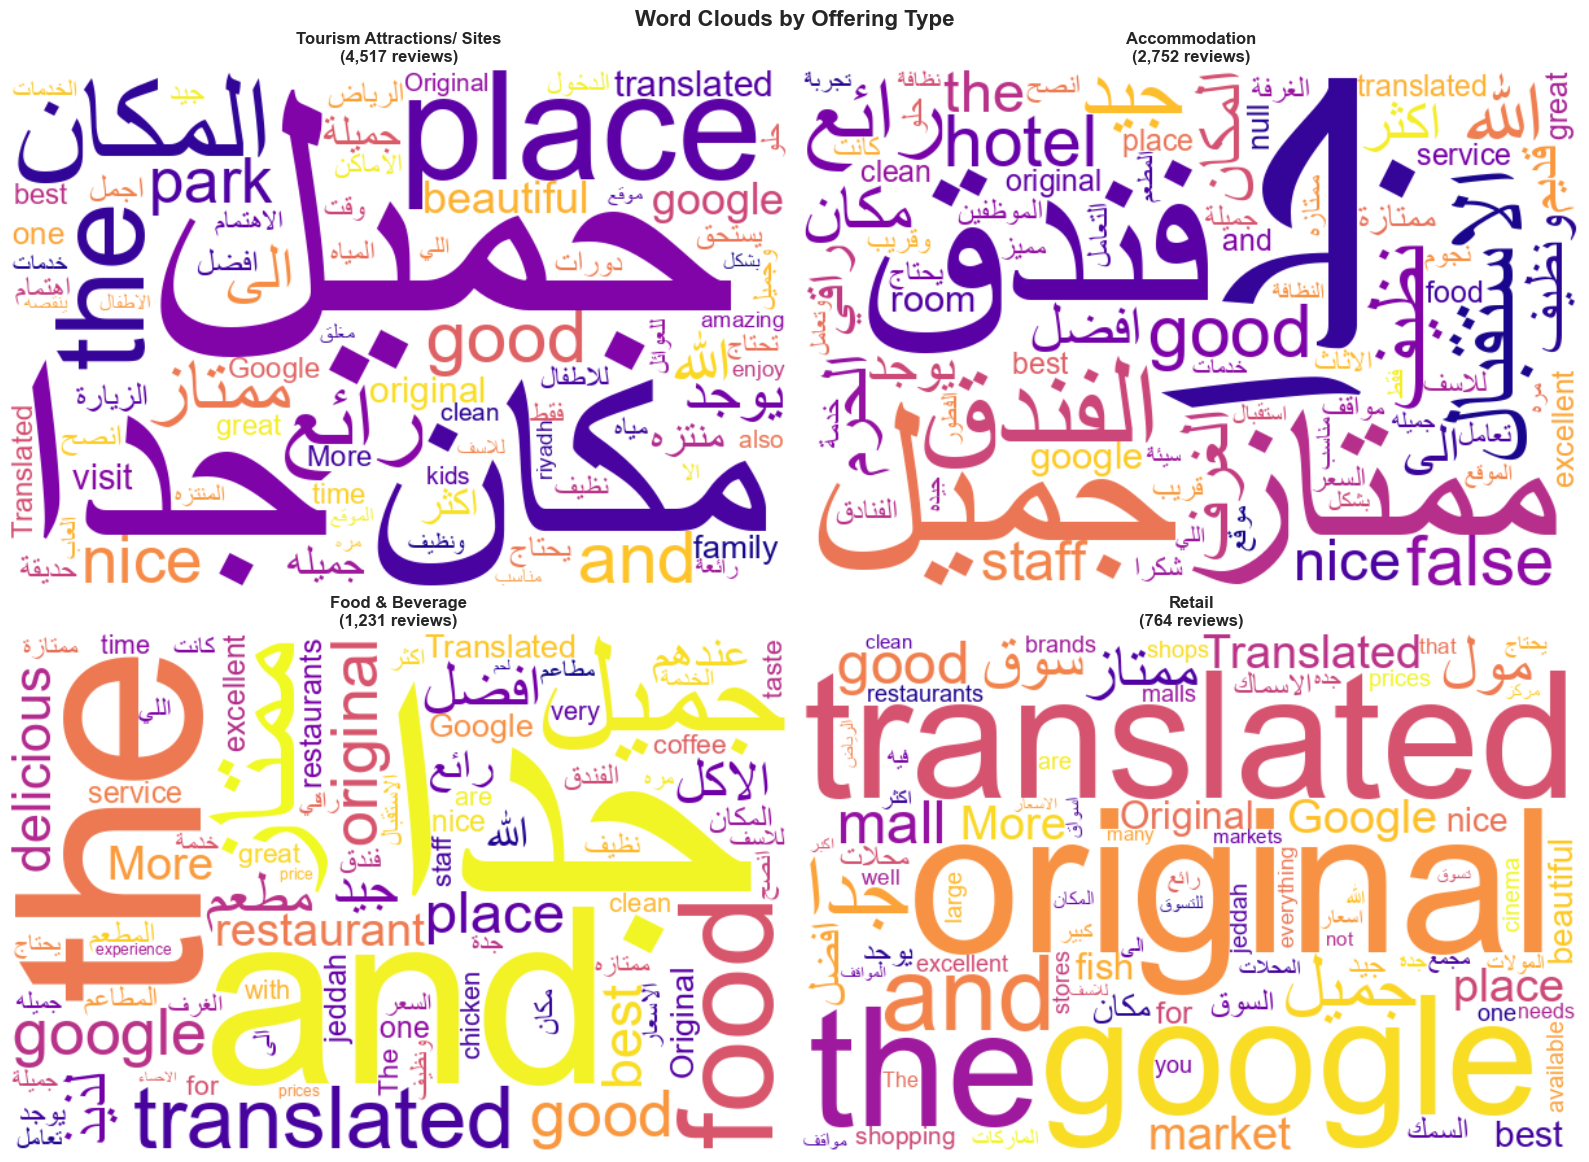

In [36]:
generate_word_clouds_by_offering(df)

# Key Findings & Insights Summary

In [37]:
# Generate comprehensive insights summary
print("="*100)
print("TOURISM REVIEWS EXPLORATORY DATA ANALYSIS - KEY FINDINGS")
print("="*100)

print("\nDATASET OVERVIEW")
print("-" * 100)
print(f"  • Total reviews analyzed: {len(df):,}")
print(f"  • Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  • Unique destinations: {df['destination'].nunique()}")
print(f"  • Offering types: {df['offer'].nunique()}")
print(f"  • Language distribution: Arabic {(df['language']=='ara').sum()/len(df)*100:.1f}%, English {(df['language']=='eng').sum()/len(df)*100:.1f}%")

print("\nRATING INSIGHTS")
print("-" * 100)
print(f"  • Average rating: {df['normalized_ratings'].mean():.2f}/100")
print(f"  • Median rating: {df['normalized_ratings'].median():.0f}/100")
print(f"  • Positive reviews (≥80): {(df['normalized_ratings'] >= 80).sum():,} ({(df['normalized_ratings'] >= 80).sum()/len(df)*100:.1f}%)")
print(f"  • Negative reviews (<40): {(df['normalized_ratings'] < 40).sum():,} ({(df['normalized_ratings'] < 40).sum()/len(df)*100:.1f}%)")

print("\nTOP DESTINATIONS")
print("-" * 100)
for i, (dest, count) in enumerate(df['destination'].value_counts().head(5).items(), 1):
    avg_rating = df[df['destination'] == dest]['normalized_ratings'].mean()
    print(f"  {i}. {dest}: {count:,} reviews (avg rating: {avg_rating:.1f}/100)")

print("\nTOP OFFERINGS")
print("-" * 100)
for i, (offer, count) in enumerate(df['offer'].value_counts().head(5).items(), 1):
    avg_rating = df[df['offer'] == offer]['normalized_ratings'].mean()
    print(f"  {i}. {offer}: {count:,} reviews (avg rating: {avg_rating:.1f}/100)")

print("\nTEXT ANALYSIS")
print("-" * 100)
print(f"  • Average review length: {df['word_count'].mean():.1f} words")
print(f"  • Median review length: {df['word_count'].median():.0f} words")
print(f"  • Total unique words: {len(set([token for tokens in df['tokens'] for token in tokens])):,}")
print(f"  • Reviews: {df['content'].notna().sum():,}")

print("\nOFFERING-SPECIFIC INSIGHTS")
print("-" * 100)
print(f"  • Religious sites have highest ratings: {df[df['offer']=='Religious']['normalized_ratings'].mean():.1f}/100")
print(f"  • Tourism Attractions have most reviews: {(df['offer']=='Tourism Attractions/ Sites').sum():,}")
print(f"  • Accommodation reviews are more detailed: {df[df['offer']=='Accommodation']['word_count'].mean():.1f} avg words")

print("\nTRENDS")
print("-" * 100)
corr = df['word_count'].corr(df['normalized_ratings'])
print(f"  • Review length vs rating correlation: {corr:.4f}")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)

TOURISM REVIEWS EXPLORATORY DATA ANALYSIS - KEY FINDINGS

DATASET OVERVIEW
----------------------------------------------------------------------------------------------------
  • Total reviews analyzed: 10,000
  • Date range: 2021-02-07 to 2023-10-03
  • Unique destinations: 22
  • Offering types: 5
  • Language distribution: Arabic 76.1%, English 23.9%

RATING INSIGHTS
----------------------------------------------------------------------------------------------------
  • Average rating: 84.01/100
  • Median rating: 100/100
  • Positive reviews (≥80): 7,786 (77.9%)
  • Negative reviews (<40): 734 (7.3%)

TOP DESTINATIONS
----------------------------------------------------------------------------------------------------
  1. Madinah: 1,851 reviews (avg rating: 85.7/100)
  2. Makkah: 1,277 reviews (avg rating: 89.0/100)
  3. Jeddah: 1,250 reviews (avg rating: 81.2/100)
  4. Riyadh: 1,208 reviews (avg rating: 80.1/100)
  5. Khobar: 731 reviews (avg rating: 85.2/100)

TOP OFFERINGS
----

## Sample Reviews

Let's examine actual review examples to understand the patterns and themes we've identified.

In [38]:
# Sample highly positive reviews
print("="*100)
print("SAMPLE HIGHLY POSITIVE REVIEWS (Rating >= 90)")
print("="*100)
positive_samples = df[df['normalized_ratings'] >= 90].sample(min(5, len(df[df['normalized_ratings'] >= 90])))
for idx, row in positive_samples.iterrows():
    print(f"\n📍 {row['destination']} | {row['offer']} | Rating: {row['normalized_ratings']}/100")
    print(f"   Title: {row['title_for_analysis']}")
    print(f"   Review: {row['text_for_analysis'][:200]}...")
    print("-" * 100)

SAMPLE HIGHLY POSITIVE REVIEWS (Rating >= 90)

📍 Khobar | Accommodation | Rating: 100.0/100
   Title: Mercure Al Khobar Hotel
   Review: افضل فندق عندي و عند العائلة، رقي في التعامل و الخدمة...
----------------------------------------------------------------------------------------------------

📍 Madinah | Religious | Rating: 100.0/100
   Title: Masjid Al Jummah
   Review: مسجد الجمعه...
----------------------------------------------------------------------------------------------------

📍 Taif | Tourism Attractions/ Sites | Rating: 100.0/100
   Title: Arruddaf Park
   Review: روعة بس نكد علينا الغبار وسني...
----------------------------------------------------------------------------------------------------

📍 Riyadh | Retail | Rating: 100.0/100
   Title: Riyadh Gallery Mall
   Review: يوجد به سباركيز للأطفال...
----------------------------------------------------------------------------------------------------

📍 Umluj | Tourism Attractions/ Sites | Rating: 100.0/100
   Title: Umluj 

In [39]:
# Sample negative reviews
print("\n" + "="*100)
print("SAMPLE NEGATIVE REVIEWS (Rating < 40)")
print("="*100)
negative_samples = df[df['normalized_ratings'] < 40].sample(min(5, len(df[df['normalized_ratings'] < 40])))
for idx, row in negative_samples.iterrows():
    print(f"\n📍 {row['destination']} | {row['offer']} | Rating: {row['normalized_ratings']}/100")
    print(f"   Title: {row['title_for_analysis']}")
    print(f"   Review: {row['text_for_analysis'][:200]}...")
    print("-" * 100)


SAMPLE NEGATIVE REVIEWS (Rating < 40)

📍 Madinah | Tourism Attractions/ Sites | Rating: 20.0/100
   Title: Falah Park
   Review: مكتوم ياليت يهتمون فيه مساحات ضايعه...
----------------------------------------------------------------------------------------------------

📍 Abha | Tourism Attractions/ Sites | Rating: 20.0/100
   Title: Al Soudah National Park
   Review: الله يازين الصيف في اندنوسيا الاسعار قليله والاجواء خورافيه...
----------------------------------------------------------------------------------------------------

📍 Tabuk | Food & Beverage | Rating: 20.0/100
   Title: Al-Qaryah Al-Turathiyah Restaurant
   Review: التصميم روعه ولكن تجربتي معهم كانت على كبسه لحم سيئ جدا اللحمة سودا وعلى حسب كلامه تيس لكن ما اضن والعلم عند الله...
----------------------------------------------------------------------------------------------------

📍 Jeddah | Retail | Rating: 20.0/100
   Title: Red Sea Mall
   Review: More(Translated by Google) Some of the secretaries dealt bitterly, I mean

In [40]:
# Sample reviews by offering type
print("\n" + "="*100)
print("SAMPLE REVIEWS BY OFFERING TYPE")
print("="*100)

for offering in df['offer'].value_counts().head(3).index:
    print(f"\n\n{'='*100}")
    print(f"{offering.upper()}")
    print('='*100)
    samples = df[df['offer'] == offering].sample(min(3, len(df[df['offer'] == offering])))
    for idx, row in samples.iterrows():
        print(f"\n📍 {row['destination']} | Rating: {row['normalized_ratings']}/100")
        print(f"   Title: {row['title_for_analysis'][:80]}...")
        print(f"   Review: {row['text_for_analysis'][:150]}...")
        print("-" * 100)


SAMPLE REVIEWS BY OFFERING TYPE


TOURISM ATTRACTIONS/ SITES

📍 Madinah | Rating: 100.0/100
   Title: Grave of Hamza ibn Abdul-Muttalib Alaihi-Mussalam...
   Review: احد جبل يحبنا ونحبه...
----------------------------------------------------------------------------------------------------

📍 Yanbu | Rating: 100.0/100
   Title: Waterfront Beach Royal Commission Yanbu...
   Review: مناسب للسباحة...
----------------------------------------------------------------------------------------------------

📍 Madinah | Rating: 80.0/100
   Title: Al Masmak Palace Museum...
   Review: Nice fort ... unfortunately when I visited there it was closed so I was not able to see it from inside....
----------------------------------------------------------------------------------------------------


ACCOMMODATION

📍 Makkah | Rating: 100.0/100
   Title: Pullman Zamzam Makkah...
   Review: ممتاز...
----------------------------------------------------------------------------------------------------

📍 Hail | 

# save the cleaned dataset

In [41]:
df.to_csv("../data/tourism_reviews.csv", index=False)

## Conclusion

This exploratory data analysis has revealed valuable insights about tourism reviews in Saudi Arabia:

### Key Takeaways:

1. **Overwhelmingly Positive Sentiment**: 77.8% of reviews are highly positive (≥80 rating), indicating strong customer satisfaction across tourism offerings.

2. **Language Diversity**: The dataset contains 76% Arabic and 24% English reviews, showcasing the importance of translation for comprehensive analysis.

3. **Top Destinations**: 
   - Religious cities (Madinah, Makkah) lead in both volume and ratings
   - Major urban centers (Jeddah, Riyadh) show diverse offerings but slightly lower ratings
   - Emerging destinations (Tabuk, Al Ahsa) maintain strong satisfaction levels

4. **Offering Performance**:
   - Religious sites achieve the highest ratings (96.5/100)
   - Tourism attractions dominate review volume (45% of all reviews)
   - Accommodation sector shows room for improvement with lower ratings

5. **Common Themes**:
   - Quality, beauty, and location are the most discussed themes
   - Cleanliness and service quality emerge as key differentiators
   - Family-friendly amenities are increasingly mentioned

6. **Review Patterns**:
   - Short, positive reviews dominate the dataset
   - Negative reviews tend to be more detailed and specific
   - Review length shows minimal correlation with rating

### Next Steps:
- Aspect-based sentiment analysis for deeper insights
- Temporal trend analysis for seasonality patterns

# Test sentiment

In [ ]:
import pandas as pd
import time
from pyabsa import AspectTermExtraction as ATEPC

# Load the PyABSA multilingual model
def load_pyabsa_model():
    try:
        print("Loading PyABSA multilingual model...")
        extractor = ATEPC.AspectExtractor('multilingual', auto_device=True)
        print("PyABSA model loaded successfully.")
        return extractor
    except Exception as e:
        print(f"Failed to load PyABSA model: {e}")
        return None

# Function to extract aspects and sentiment from the text
def extract_aspects_from_text(extractor, text):
    try:
        start_time = time.time()
        # Extract aspects and sentiment using the model
        results = extractor.predict(
            [text], 
            print_result=False,
            save_result=False,
            ignore_error=True,
            pred_sentiment=True
        )
        
        processing_time_ms = int((time.time() - start_time) * 1000)
        
        if not results or len(results) == 0:
            print(f"No results found for text: {text}")
            return []
        
        # Extract the first result (since we only sent one text)
        pyabsa_result = results[0]
        
        # Extract aspects, sentiments, and confidences
        aspects = []
        for i, aspect in enumerate(pyabsa_result['aspect']):
            sentiment = pyabsa_result['sentiment'][i] if i < len(pyabsa_result['sentiment']) else 'Neutral'
            confidence = pyabsa_result['confidence'][i] if i < len(pyabsa_result['confidence']) else 0.0
            evidence_span = ' '.join([pyabsa_result['tokens'][idx] for idx in pyabsa_result['position'][i]]) if pyabsa_result['position'] else aspect

            aspects.append({
                "aspect": aspect,
                "evidence_span": evidence_span,
                "polarity": sentiment,
                "confidence": confidence
            })
        
        return {
            "aspects": aspects,
            "meta": {
                "model": "pyabsa-multilingual",
                "latency_ms": processing_time_ms
            }
        }
    
    except Exception as e:
        print(f"Error during sentiment extraction: {e}")
        return []

# Your dataset (example)
data = [
    {
        'id': '377380-203583770957',
        'content': 'من الاماكن الهاديه الجميله الممتعه في التسوق تحس انك بالخبر',
        'language': 'ara',
        'text_for_analysis': 'من الاماكن الهاديه الجميله الممتعه في التسوق تحس انك بالخبر'
    },
    {
        'id': '377380-203585579625',
        'content': 'مساحة خضراء تتنفس فيها الهواء النقي .. المناظر الطبيعية ..الالعاب الترفيهية المناسبة للأطفال 😍😍 بحر الخليج',
        'language': 'ara',
        'text_for_analysis': 'مساحة خضراء تتنفس فيها الهواء النقي .. المناظر الطبيعية ..الالعاب الترفيهية المناسبة للأطفال 😍😍 بحر الخليج'
    },
    {
        'id': '377380-203590496913',
        'content': 'nice place',
        'language': 'eng',
        'text_for_analysis': 'nice place'
    }
]

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Load the model
extractor = load_pyabsa_model()

# Initialize a list to store the results
flattened_results = []

# Process each row in the dataset
for _, row in df.iterrows():
    text = row['text_for_analysis']
    result = extract_aspects_from_text(extractor, text)
    
    if result:  # Check if there are any results
        # Flatten the aspects and add to the results
        for aspect in result['aspects']:
            flattened_results.append({
                'id': row['id'],
                'content': row['content'],
                'language': row['language'],
                'aspect': aspect['aspect'],
                'evidence_span': aspect['evidence_span'],
                'polarity': aspect['polarity'],
                'confidence': aspect['confidence'],
                'model': result['meta']['model'],
                'latency_ms': result['meta']['latency_ms']
            })

# Convert the flattened results to a DataFrame
flattened_df = pd.DataFrame(flattened_results)

# Show the flattened DataFrame
print(flattened_df)
